In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import random, uniform
import math

In [2]:
class GenerateData:
    @staticmethod
    def generate_linear(n=100):
        pts = np.random.uniform(0, 1, (n, 2))
        inputs = []
        labels = []
        for pt in pts:
            inputs.append([pt[0], pt[1]])
            distance = (pt[0] - pt[1]) / 1.414
            if pt[0] > pt[1]:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(inputs), np.array(labels).reshape(n, 1)
    
    @staticmethod
    def generate_XOR_easy():
        inputs = []
        labels = []

        for i in range(11):
            inputs.append([0.1*i, 0.1*i])
            labels.append(0)

            if 0.1*i == 0.5:
                continue

            inputs.append([0.1*i, 1-0.1*i])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape(21, 1)

In [3]:
def show_result(x, y, pred_y):
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth", fontsize = 18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
            
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
            
    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize = 18)
    for i in range(x.shape[0]):
        if abs(pred_y[i]) >=0.9:
            plt.plot(x[i][0], x[i][1], 'bo')
            print("print Blue", pred_y[i])
            
        else:
            plt.plot(x[i][0], x[i][1], 'ro')
            print("print Red", pred_y[i])
            
    plt.show()

In [4]:
def show_accuracy(Y_train, Y_predict):
    correct = 0
    for i in range(len(Y_predict)):
        if Y_train[i][0]==0 and (Y_predict[i] < 0.9):
            correct += 1
        elif Y_train[i][0]==1 and (Y_predict[i] >= 0.9):
            correct += 1
    print(f"Accuracy--> {round(correct/len(Y_predict), 3)*100}%")

In [5]:
class SimpleNN:
    def __init__(self):
        self.network = list()
        self.neuronNum = list()
        self.l_rate = 0.01
        self.n_epoch = 1000
        self.haveLearningCurve = True
        self.showLoss = 1
        seed(1)
    def addLayer(self, n_neuron, **karg):
        if "n_inputs" in karg.keys():
            #This is input layer
            n_inputs = karg['n_inputs']
            inputLayer = [{"weight":[uniform(-1, 1)  for __ in range(n_inputs+1)]}for _ in range(n_neuron)] #weight[-1] is for Bias
            self.network.append(inputLayer)
            self.neuronNum.append(n_inputs)
            self.neuronNum.append(n_neuron)
        else:
            #This is hidden/output layer
            try:
                if len(self.neuronNum)>0:
                    n_previousNeuron = self.neuronNum[-1]
                    middleLayer = [{"weight":[uniform(-1, 1) for __ in range(n_previousNeuron+1)]}for _ in range(n_neuron)]
                    self.network.append(middleLayer)
                    self.neuronNum.append(n_neuron)
                else:
                    raise Exception('Error Layer! (You must check last layer.(Or you miss n_inputs parameter there?))')

            except Exception as error:
                print('Caught this error: ' + repr(error))
    def setting(self, l_rate, n_epoch, haveLearningCurve=True, showLoss=1):
        self.l_rate = l_rate
        self.n_epoch = n_epoch
        self.haveLearningCurve = haveLearningCurve
        self.showLoss = showLoss
        print("----Training Setting----")
        print(f"Epoch:{self.n_epoch}")
        print(f"Learning Rate:{self.l_rate}")
        print(f"Learning Curve:{self.haveLearningCurve}")
        print(f"Show Loss Frequency:{self.showLoss}")
        print("------------------------")
        
    def describe(self):
        print("----Network Description----")
        print(f"total {len(self.network)} layers")
        print(f"{len(self.network)-1} hidden layer")
        print("one output layer")
        for index, layer in enumerate(self.network):
            print(f"-Layer {index+1}-")
            print(f"{len(layer)} neurons")
            for neu_index, neuron in enumerate(layer):
                print(f"neuron{neu_index}:")
                print(f"weight:{neuron['weight'][:-1]}")
                print(f"bias:{neuron['weight'][-1]}")
        print("---------------------------")
    
    #Caculate "net" value
    #weights(List): the weight between inputs and neurons. Notice: weights[-1] is the bias. 
    #inputs(List): X_train or the outputs of previous layer
    def activateProcess(self, weights, inputs):
        bias = weights[-1]
        value = -bias
        for i in range(len(weights)-1):
            value += weights[i]*inputs[i]
        return value
    
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
    
    def foward(self, rowData):
        inputs = rowData #get input data(by one data) Ex. x[0]~x[n]
    #     print("forward_input",inputs)
        for layer in self.network:
            new_inputs = list()
            for neuron in layer:
                output = self.activateProcess(neuron["weight"], inputs)
                output_sigmoid = self.sigmoid(output)
                neuron["output"] = output_sigmoid
                new_inputs.append(output_sigmoid)
            inputs = new_inputs
        return inputs
    
    def derivate_sigmoid(self, x):
        return x * (1.0 - x)
    
    #groundTruth: y(List), y[0]~y[n]
    def backwardPropagation(self, groundTruth):
        for i in reversed(range(len(self.network))):
            if i == (len(self.network)-1):
                #It is a  output layer!
                for index, neuron in enumerate(self.network[i]):
                    diff = groundTruth[index]-neuron['output']
                    neuron['delta'] = diff  #The Derivative of MSE -> -(T-Y)
            else:
                #It is not a ouput layer!
                for index, neuron in enumerate(self.network[i]):
                    error = 0
                    for nextNeuron in self.network[i+1]:
                        error += nextNeuron['weight'][index] * nextNeuron['delta']
                    neuron['delta'] = error

            for neuron in self.network[i]:
                neuron['delta'] = neuron['delta'] * self.derivate_sigmoid(neuron['output'])
    
    #initInputs: Original input(X_train)
    def updateWeight(self, initInputs):
        inputs = initInputs
        tempInput = list()
        for nowIndex, layer in enumerate(self.network):
            if nowIndex != 0:
                # Not First Hidden layer
                inputs = tempInput.copy()
                tempInput.clear()
            for neuron in layer:
                for index, inputItem in enumerate(inputs):
                    neuron['weight'][index] +=  self.l_rate * neuron['delta'] * inputItem #For weight
                neuron['weight'][-1] += -(self.l_rate) * neuron['delta'] # For Bias
                tempInput.append(neuron['output'])
                
    def learningCurve(self):
        plt.title("Learning Curve", fontsize = 18)
        plt.plot([x for x in range(1,self.n_epoch+1)], self.errorList,color='blue', label="learning curve")
        plt.legend(loc = 'upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def trainNetwork(self, X_train, Y_train):
        print("----Training Setting----")
        print(f"Epoch:{self.n_epoch}")
        print(f"Learning Rate:{self.l_rate}")
        print(f"Learning Curve:{self.haveLearningCurve}")
        print(f"Show Loss Frequency:{self.showLoss}")
        print("------------------------")
        self.describe()
        
        errorList = list()
        for epoch in range(self.n_epoch):
            sum_error = 0
            for index, row in enumerate(X_train):
                #row: [0.1, 0.2]
                Y_predict = self.foward(row) #n_outputs dimension
                sum_error += sum([(Y_train[index][i]-Y_predict[i])**2 for i in range(self.neuronNum[-1])]) 
                self.backwardPropagation(Y_train[index])
                self.updateWeight(row)
            error = sum_error/len(X_train)
            errorList.append(round(error, 3))
            if not (epoch%self.showLoss):
                print('==epoch=%d, lrate=%.3f, error=%.3f==' % (epoch, self.l_rate, error))
        self.errorList = errorList
        if self.haveLearningCurve:
            self.learningCurve()
    
    def predict(self, X_test):
        result = list()
        for index, row in enumerate(X_test):
            print(f"Predict:{index}, {row}")
            Y_predict = self.foward(row)
            result.append(Y_predict[0])
        return result

    
        

In [11]:
X_xor_train, Y_xor_train = GenerateData.generate_XOR_easy()
xorNN = SimpleNN()

In [12]:
xorNN.addLayer(n_neuron=2, n_inputs=2)
xorNN.addLayer(n_neuron=2)
xorNN.addLayer(n_neuron=1)

In [13]:
xorNN.describe()

----Network Description----
total 3 layers
2 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------


In [14]:
xorNN.setting(l_rate=4, n_epoch=2000, showLoss=10)

----Training Setting----
Epoch:2000
Learning Rate:4
Learning Curve:True
Show Loss Frequency:10
------------------------


----Training Setting----
Epoch:2000
Learning Rate:4
Learning Curve:True
Show Loss Frequency:10
------------------------
----Network Description----
total 3 layers
2 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------
==epoch=0, lrate=4.000, error=0.381==
==epoch=10, lrate=4.000, error=0.324==
==epoch=20, lrate=4.000, error=0.322==
==epoch=30, lrate=4.000, error=0.321==
==epoch=40, lrate=4.000, error=0.321==
==epoch=50, lrate=4.000, error=0.321==
==epoch=60, lrate=4.000, error=0.321==
==epoch=70, lrate=4.000, er

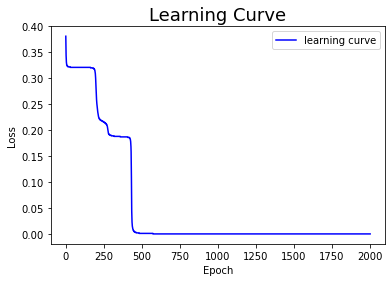

In [15]:
xorNN.trainNetwork(X_xor_train, Y_xor_train)

In [16]:
Y_xor_predict = xorNN.predict(X_xor_train)

Predict:0, [0. 0.]
Predict:1, [0. 1.]
Predict:2, [0.1 0.1]
Predict:3, [0.1 0.9]
Predict:4, [0.2 0.2]
Predict:5, [0.2 0.8]
Predict:6, [0.3 0.3]
Predict:7, [0.3 0.7]
Predict:8, [0.4 0.4]
Predict:9, [0.4 0.6]
Predict:10, [0.5 0.5]
Predict:11, [0.6 0.6]
Predict:12, [0.6 0.4]
Predict:13, [0.7 0.7]
Predict:14, [0.7 0.3]
Predict:15, [0.8 0.8]
Predict:16, [0.8 0.2]
Predict:17, [0.9 0.9]
Predict:18, [0.9 0.1]
Predict:19, [1. 1.]
Predict:20, [1. 0.]


print Red 0.0057238406469684025
print Blue 0.9943560117436028
print Red 0.0057609186050661485
print Blue 0.9943450313855666
print Red 0.005796195613487858
print Blue 0.9943194550526196
print Red 0.0058294496977449655
print Blue 0.9940878556500395
print Red 0.005860539300573677
print Blue 0.9878042974141095
print Red 0.005889401181132793
print Red 0.00591604347059337
print Blue 0.9905666848919757
print Red 0.005940535352723474
print Blue 0.9950329713193993
print Red 0.005962994908848111
print Blue 0.9952532466408688
print Red 0.005983576506082436
print Blue 0.9953003508383542
print Red 0.006002458807989321
print Blue 0.9953297893710781


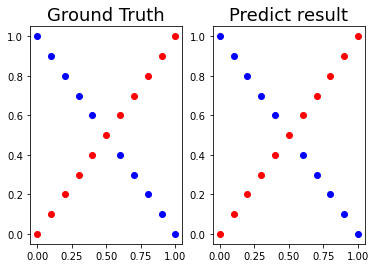

Accuracy--> 100.0%


In [17]:
show_result(X_xor_train, Y_xor_train, Y_xor_predict)
show_accuracy(Y_xor_train, Y_xor_predict)

In [27]:
X_linear_train, Y_linear_train = GenerateData.generate_linear(100)
linearNN = SimpleNN()

In [28]:
linearNN.addLayer(n_neuron=2, n_inputs=2)
linearNN.addLayer(n_neuron=2)
linearNN.addLayer(n_neuron=1)

In [29]:
linearNN.describe()

----Network Description----
total 3 layers
2 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------


In [30]:
linearNN.setting(l_rate=0.1, n_epoch=3000, haveLearningCurve=True, showLoss=5)

----Training Setting----
Epoch:3000
Learning Rate:0.1
Learning Curve:True
Show Loss Frequency:5
------------------------


----Training Setting----
Epoch:3000
Learning Rate:0.1
Learning Curve:True
Show Loss Frequency:5
------------------------
----Network Description----
total 3 layers
2 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------
==epoch=0, lrate=0.100, error=0.246==
==epoch=5, lrate=0.100, error=0.242==
==epoch=10, lrate=0.100, error=0.241==
==epoch=15, lrate=0.100, error=0.239==
==epoch=20, lrate=0.100, error=0.236==
==epoch=25, lrate=0.100, error=0.232==
==epoch=30, lrate=0.100, error=0.225==
==epoch=35, lrate=0.100, er

==epoch=945, lrate=0.100, error=0.004==
==epoch=950, lrate=0.100, error=0.004==
==epoch=955, lrate=0.100, error=0.004==
==epoch=960, lrate=0.100, error=0.004==
==epoch=965, lrate=0.100, error=0.004==
==epoch=970, lrate=0.100, error=0.004==
==epoch=975, lrate=0.100, error=0.004==
==epoch=980, lrate=0.100, error=0.004==
==epoch=985, lrate=0.100, error=0.004==
==epoch=990, lrate=0.100, error=0.004==
==epoch=995, lrate=0.100, error=0.004==
==epoch=1000, lrate=0.100, error=0.004==
==epoch=1005, lrate=0.100, error=0.004==
==epoch=1010, lrate=0.100, error=0.004==
==epoch=1015, lrate=0.100, error=0.004==
==epoch=1020, lrate=0.100, error=0.004==
==epoch=1025, lrate=0.100, error=0.004==
==epoch=1030, lrate=0.100, error=0.004==
==epoch=1035, lrate=0.100, error=0.004==
==epoch=1040, lrate=0.100, error=0.004==
==epoch=1045, lrate=0.100, error=0.004==
==epoch=1050, lrate=0.100, error=0.004==
==epoch=1055, lrate=0.100, error=0.004==
==epoch=1060, lrate=0.100, error=0.004==
==epoch=1065, lrate=0.100, 

==epoch=2000, lrate=0.100, error=0.002==
==epoch=2005, lrate=0.100, error=0.002==
==epoch=2010, lrate=0.100, error=0.002==
==epoch=2015, lrate=0.100, error=0.002==
==epoch=2020, lrate=0.100, error=0.002==
==epoch=2025, lrate=0.100, error=0.002==
==epoch=2030, lrate=0.100, error=0.002==
==epoch=2035, lrate=0.100, error=0.002==
==epoch=2040, lrate=0.100, error=0.002==
==epoch=2045, lrate=0.100, error=0.002==
==epoch=2050, lrate=0.100, error=0.002==
==epoch=2055, lrate=0.100, error=0.002==
==epoch=2060, lrate=0.100, error=0.002==
==epoch=2065, lrate=0.100, error=0.002==
==epoch=2070, lrate=0.100, error=0.002==
==epoch=2075, lrate=0.100, error=0.002==
==epoch=2080, lrate=0.100, error=0.002==
==epoch=2085, lrate=0.100, error=0.002==
==epoch=2090, lrate=0.100, error=0.002==
==epoch=2095, lrate=0.100, error=0.002==
==epoch=2100, lrate=0.100, error=0.002==
==epoch=2105, lrate=0.100, error=0.002==
==epoch=2110, lrate=0.100, error=0.002==
==epoch=2115, lrate=0.100, error=0.002==
==epoch=2120, lr

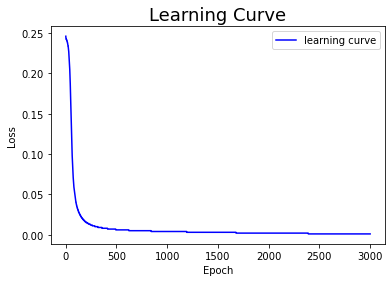

In [31]:
linearNN.trainNetwork(X_linear_train, Y_linear_train)

In [32]:
Y_linear_predict = linearNN.predict(X_linear_train)

Predict:0, [0.73725171 0.80793252]
Predict:1, [0.07624783 0.37820341]
Predict:2, [0.9496633 0.8646757]
Predict:3, [0.99105017 0.29174927]
Predict:4, [0.16163339 0.68102582]
Predict:5, [0.83319693 0.20804006]
Predict:6, [0.61481785 0.12754157]
Predict:7, [0.00608432 0.24989989]
Predict:8, [0.29348547 0.98963078]
Predict:9, [0.44815635 0.0697414 ]
Predict:10, [0.30255055 0.37004041]
Predict:11, [0.02543196 0.82562748]
Predict:12, [0.90252707 0.22349092]
Predict:13, [0.2930779  0.87680061]
Predict:14, [0.50255903 0.03787423]
Predict:15, [0.68153313 0.76526174]
Predict:16, [0.03559966 0.64489854]
Predict:17, [0.26768417 0.53248436]
Predict:18, [0.03125726 0.04674979]
Predict:19, [0.20182123 0.93755403]
Predict:20, [0.72691132 0.90318163]
Predict:21, [0.73935432 0.87201305]
Predict:22, [0.1262445  0.34777521]
Predict:23, [0.87891428 0.37199979]
Predict:24, [0.51873219 0.64639342]
Predict:25, [0.02725153 0.46685862]
Predict:26, [0.1524525  0.14859371]
Predict:27, [0.71603401 0.13029012]
Pred

print Blue 0.929104314515103
print Blue 0.9998563118116579
print Red 0.0002243148380141095
print Red 7.265539747212164e-05
print Blue 0.9998733607824846
print Red 7.364303679504506e-05
print Red 7.646678530964252e-05
print Blue 0.9998408812427716
print Blue 0.9998771919989101
print Red 8.120397416742738e-05
print Blue 0.992023623418727
print Blue 0.9998786822463995
print Red 7.290972232560837e-05
print Blue 0.9998750176838762
print Red 7.724556820885748e-05
print Blue 0.9850169967853335
print Blue 0.9998757066452033
print Blue 0.9998431181477397
print Red 0.8049546058013106
print Blue 0.9998778086297875
print Blue 0.9996615807134935
print Blue 0.9989961499987552
print Blue 0.9998253371556391
print Red 7.578739196750023e-05
print Blue 0.9992584300181458
print Blue 0.9998703916849061
print Red 0.1503412932414191
print Red 7.429673492481971e-05
print Blue 0.9997902195673632
print Red 7.531228395093916e-05
print Red 0.0003634825708983947
print Blue 0.9998494814066692
print Blue 0.999842173

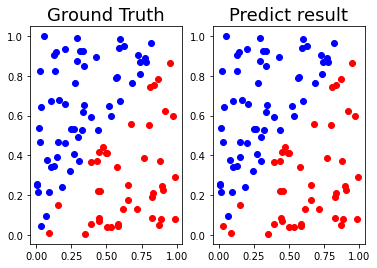

Accuracy--> 99.0%


In [33]:
show_result(X_linear_train, Y_linear_train, Y_linear_predict)
show_accuracy(Y_linear_train, Y_linear_predict)

In [34]:
class SimpleNNNonActivate:
    def __init__(self):
        self.network = list()
        self.neuronNum = list()
        self.l_rate = 0.01
        self.n_epoch = 1000
        self.haveLearningCurve = True
        seed(1)
    def addLayer(self, n_neuron, **karg):
        if "n_inputs" in karg.keys():
            #This is input layer
            n_inputs = karg['n_inputs']
            inputLayer = [{"weight":[uniform(-1,1)  for __ in range(n_inputs+1)]}for _ in range(n_neuron)] #weight[-1] is for Bias
            self.network.append(inputLayer)
            self.neuronNum.append(n_inputs)
            self.neuronNum.append(n_neuron)
        else:
            #This is hidden/output layer
            try:
                if len(self.neuronNum)>0:
                    n_previousNeuron = self.neuronNum[-1]
                    middleLayer = [{"weight":[uniform(-1,1)    for __ in range(n_previousNeuron+1)]}for _ in range(n_neuron)]
                    self.network.append(middleLayer)
                    self.neuronNum.append(n_neuron)
                else:
                    raise Exception('Error Layer! (You must check last layer.(Or you miss n_inputs parameter there?))')

            except Exception as error:
                print('Caught this error: ' + repr(error))
    def setting(self, l_rate, n_epoch, haveLearningCurve=True ):
        self.l_rate = l_rate
        self.n_epoch = n_epoch
        self.haveLearningCurve = haveLearningCurve
        print("----Training Setting----")
        print(f"Epoch:{self.n_epoch}")
        print(f"Learning Rate:{self.l_rate}")
        print(f"Learning Curve:{self.haveLearningCurve}")
        print("------------------------")
        
    def describe(self):
        print("----Network Description----")
        print(f"total {len(self.network)} layers")
        print(f"{len(self.network)-1} hidden layer")
        print("one output layer")
        for index, layer in enumerate(self.network):
            print(f"-Layer {index+1}-")
            print(f"{len(layer)} neurons")
            for neu_index, neuron in enumerate(layer):
                print(f"neuron{neu_index}:")
                print(f"weight:{neuron['weight'][:-1]}")
                print(f"bias:{neuron['weight'][-1]}")
        print("---------------------------")
    
    #Caculate "net" value
    #weights(List): the weight between inputs and neurons. Notice: weights[-1] is the bias. 
    #inputs(List): X_train or the outputs of previous layer
    def activateProcess(self, weights, inputs):
        bias = weights[-1]
        value = -bias
        for i in range(len(weights)-1):
            value += weights[i]*inputs[i]
        return value
    
    def sigmoid(self, x):
        return x #Not to do anything
    
    def foward(self, rowData):
        inputs = rowData #get input data(by one data) Ex. x[0]~x[n]
    #     print("forward_input",inputs)
        for layer in self.network:
            new_inputs = list()
            for neuron in layer:
                output = self.activateProcess(neuron["weight"], inputs)
                output_sigmoid = self.sigmoid(output)
                neuron["output"] = output_sigmoid
                new_inputs.append(output_sigmoid)
            inputs = new_inputs
        return inputs
    
    def derivate_sigmoid(self, x):
        return 1
    
    #groundTruth: y(List), y[0]~y[n]
    def backwardPropagation(self, groundTruth):
        for i in reversed(range(len(self.network))):
            if i == (len(self.network)-1):
                #It is a  output layer!
                for index, neuron in enumerate(self.network[i]):
                    diff = groundTruth[index]-neuron['output']
                    neuron['delta'] = diff  #The Derivative of MSE -> -(T-Y)
            else:
                #It is not a ouput layer!
                for index, neuron in enumerate(self.network[i]):
                    error = 0
                    for nextNeuron in self.network[i+1]:
                        error += nextNeuron['weight'][index] * nextNeuron['delta']
                    neuron['delta'] = error

            for neuron in self.network[i]:
                neuron['delta'] = neuron['delta'] * self.derivate_sigmoid(neuron['output'])
    
    #initInputs: Original input(X_train)
    def updateWeight(self, initInputs):
        inputs = initInputs
        tempInput = list()
        for nowIndex, layer in enumerate(self.network):
            if nowIndex != 0:
                # Not First Hidden layer
                inputs = tempInput.copy()
                tempInput.clear()
            for neuron in layer:
                for index, inputItem in enumerate(inputs):
                    neuron['weight'][index] +=  self.l_rate * neuron['delta'] * inputItem #For weight
                neuron['weight'][-1] += -(self.l_rate) * neuron['delta'] # For Bias
                tempInput.append(neuron['output'])
                
    def learningCurve(self):
        plt.title("Learning Curve", fontsize = 18)
        plt.plot([x for x in range(1,self.n_epoch+1)], self.errorList,color='blue', label="learning curve")
        plt.legend(loc = 'upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def trainNetwork(self, X_train, Y_train):
        print("----Training Setting----")
        print(f"Epoch:{self.n_epoch}")
        print(f"Learning Rate:{self.l_rate}")
        print(f"Learning Curve:{self.haveLearningCurve}")
        print("------------------------")
        self.describe()
        
        errorList = list()
        for epoch in range(self.n_epoch):
            sum_error = 0
            for index, row in enumerate(X_train):
                #row: [0.1, 0.2]
                Y_predict = self.foward(row) #n_outputs dimension
                sum_error += sum([(Y_train[index][i]-Y_predict[i])**2 for i in range(self.neuronNum[-1])]) 
                self.backwardPropagation(Y_train[index])
                self.updateWeight(row)
            error = sum_error/len(X_train)
            errorList.append(round(error, 3))
            print('==epoch=%d, lrate=%.3f, error=%.3f==' % (epoch, self.l_rate, error))
        self.errorList = errorList
        if self.haveLearningCurve:
            self.learningCurve()
    
    def predict(self, X_test):
        result = list()
        for index, row in enumerate(X_test):
            print(f"Predict:{index}, {row}")
            Y_predict = self.foward(row)
            result.append(Y_predict[0])
        return result

    
        

In [42]:
X_non_train, Y_non_train = GenerateData.generate_linear()
xorNNNon = SimpleNNNonActivate()

In [43]:
xorNNNon.addLayer(n_neuron=2, n_inputs=2)
xorNNNon.addLayer(n_neuron=2)
xorNNNon.addLayer(n_neuron=1)

In [44]:
xorNNNon.setting(l_rate=0.42, n_epoch=9500)

----Training Setting----
Epoch:9500
Learning Rate:0.42
Learning Curve:True
------------------------


In [45]:
xorNNNon.describe()

----Network Description----
total 3 layers
2 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------


----Training Setting----
Epoch:9500
Learning Rate:0.42
Learning Curve:True
------------------------
----Network Description----
total 3 layers
2 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------
==epoch=0, lrate=0.420, error=0.230==
==epoch=1, lrate=0.420, error=0.192==
==epoch=2, lrate=0.420, error=0.190==
==epoch=3, lrate=0.420, error=0.189==
==epoch=4, lrate=0.420, error=0.189==
==epoch=5, lrate=0.420, error=0.189==
==epoch=6, lrate=0.420, error=0.189==
==epoch=7, lrate=0.420, error=0.189==
==epoch=8, lrat

==epoch=222, lrate=0.420, error=0.190==
==epoch=223, lrate=0.420, error=0.190==
==epoch=224, lrate=0.420, error=0.190==
==epoch=225, lrate=0.420, error=0.190==
==epoch=226, lrate=0.420, error=0.190==
==epoch=227, lrate=0.420, error=0.190==
==epoch=228, lrate=0.420, error=0.190==
==epoch=229, lrate=0.420, error=0.190==
==epoch=230, lrate=0.420, error=0.190==
==epoch=231, lrate=0.420, error=0.190==
==epoch=232, lrate=0.420, error=0.190==
==epoch=233, lrate=0.420, error=0.190==
==epoch=234, lrate=0.420, error=0.190==
==epoch=235, lrate=0.420, error=0.190==
==epoch=236, lrate=0.420, error=0.190==
==epoch=237, lrate=0.420, error=0.190==
==epoch=238, lrate=0.420, error=0.190==
==epoch=239, lrate=0.420, error=0.190==
==epoch=240, lrate=0.420, error=0.190==
==epoch=241, lrate=0.420, error=0.190==
==epoch=242, lrate=0.420, error=0.190==
==epoch=243, lrate=0.420, error=0.190==
==epoch=244, lrate=0.420, error=0.190==
==epoch=245, lrate=0.420, error=0.190==
==epoch=246, lrate=0.420, error=0.190==


==epoch=427, lrate=0.420, error=0.190==
==epoch=428, lrate=0.420, error=0.190==
==epoch=429, lrate=0.420, error=0.190==
==epoch=430, lrate=0.420, error=0.190==
==epoch=431, lrate=0.420, error=0.190==
==epoch=432, lrate=0.420, error=0.190==
==epoch=433, lrate=0.420, error=0.190==
==epoch=434, lrate=0.420, error=0.190==
==epoch=435, lrate=0.420, error=0.190==
==epoch=436, lrate=0.420, error=0.190==
==epoch=437, lrate=0.420, error=0.190==
==epoch=438, lrate=0.420, error=0.190==
==epoch=439, lrate=0.420, error=0.190==
==epoch=440, lrate=0.420, error=0.190==
==epoch=441, lrate=0.420, error=0.190==
==epoch=442, lrate=0.420, error=0.190==
==epoch=443, lrate=0.420, error=0.190==
==epoch=444, lrate=0.420, error=0.190==
==epoch=445, lrate=0.420, error=0.190==
==epoch=446, lrate=0.420, error=0.190==
==epoch=447, lrate=0.420, error=0.190==
==epoch=448, lrate=0.420, error=0.190==
==epoch=449, lrate=0.420, error=0.190==
==epoch=450, lrate=0.420, error=0.190==
==epoch=451, lrate=0.420, error=0.190==


==epoch=639, lrate=0.420, error=0.190==
==epoch=640, lrate=0.420, error=0.190==
==epoch=641, lrate=0.420, error=0.190==
==epoch=642, lrate=0.420, error=0.190==
==epoch=643, lrate=0.420, error=0.190==
==epoch=644, lrate=0.420, error=0.190==
==epoch=645, lrate=0.420, error=0.190==
==epoch=646, lrate=0.420, error=0.190==
==epoch=647, lrate=0.420, error=0.190==
==epoch=648, lrate=0.420, error=0.190==
==epoch=649, lrate=0.420, error=0.190==
==epoch=650, lrate=0.420, error=0.190==
==epoch=651, lrate=0.420, error=0.190==
==epoch=652, lrate=0.420, error=0.190==
==epoch=653, lrate=0.420, error=0.190==
==epoch=654, lrate=0.420, error=0.190==
==epoch=655, lrate=0.420, error=0.190==
==epoch=656, lrate=0.420, error=0.190==
==epoch=657, lrate=0.420, error=0.190==
==epoch=658, lrate=0.420, error=0.190==
==epoch=659, lrate=0.420, error=0.190==
==epoch=660, lrate=0.420, error=0.190==
==epoch=661, lrate=0.420, error=0.190==
==epoch=662, lrate=0.420, error=0.190==
==epoch=663, lrate=0.420, error=0.190==


==epoch=847, lrate=0.420, error=0.190==
==epoch=848, lrate=0.420, error=0.190==
==epoch=849, lrate=0.420, error=0.190==
==epoch=850, lrate=0.420, error=0.190==
==epoch=851, lrate=0.420, error=0.190==
==epoch=852, lrate=0.420, error=0.190==
==epoch=853, lrate=0.420, error=0.190==
==epoch=854, lrate=0.420, error=0.190==
==epoch=855, lrate=0.420, error=0.190==
==epoch=856, lrate=0.420, error=0.190==
==epoch=857, lrate=0.420, error=0.190==
==epoch=858, lrate=0.420, error=0.190==
==epoch=859, lrate=0.420, error=0.190==
==epoch=860, lrate=0.420, error=0.190==
==epoch=861, lrate=0.420, error=0.190==
==epoch=862, lrate=0.420, error=0.190==
==epoch=863, lrate=0.420, error=0.190==
==epoch=864, lrate=0.420, error=0.190==
==epoch=865, lrate=0.420, error=0.190==
==epoch=866, lrate=0.420, error=0.190==
==epoch=867, lrate=0.420, error=0.190==
==epoch=868, lrate=0.420, error=0.190==
==epoch=869, lrate=0.420, error=0.190==
==epoch=870, lrate=0.420, error=0.190==
==epoch=871, lrate=0.420, error=0.190==


==epoch=1097, lrate=0.420, error=0.190==
==epoch=1098, lrate=0.420, error=0.190==
==epoch=1099, lrate=0.420, error=0.190==
==epoch=1100, lrate=0.420, error=0.190==
==epoch=1101, lrate=0.420, error=0.190==
==epoch=1102, lrate=0.420, error=0.190==
==epoch=1103, lrate=0.420, error=0.190==
==epoch=1104, lrate=0.420, error=0.190==
==epoch=1105, lrate=0.420, error=0.190==
==epoch=1106, lrate=0.420, error=0.190==
==epoch=1107, lrate=0.420, error=0.190==
==epoch=1108, lrate=0.420, error=0.190==
==epoch=1109, lrate=0.420, error=0.190==
==epoch=1110, lrate=0.420, error=0.190==
==epoch=1111, lrate=0.420, error=0.190==
==epoch=1112, lrate=0.420, error=0.190==
==epoch=1113, lrate=0.420, error=0.190==
==epoch=1114, lrate=0.420, error=0.190==
==epoch=1115, lrate=0.420, error=0.190==
==epoch=1116, lrate=0.420, error=0.190==
==epoch=1117, lrate=0.420, error=0.190==
==epoch=1118, lrate=0.420, error=0.190==
==epoch=1119, lrate=0.420, error=0.190==
==epoch=1120, lrate=0.420, error=0.190==
==epoch=1121, lr

==epoch=1348, lrate=0.420, error=0.190==
==epoch=1349, lrate=0.420, error=0.190==
==epoch=1350, lrate=0.420, error=0.190==
==epoch=1351, lrate=0.420, error=0.190==
==epoch=1352, lrate=0.420, error=0.190==
==epoch=1353, lrate=0.420, error=0.190==
==epoch=1354, lrate=0.420, error=0.190==
==epoch=1355, lrate=0.420, error=0.190==
==epoch=1356, lrate=0.420, error=0.190==
==epoch=1357, lrate=0.420, error=0.190==
==epoch=1358, lrate=0.420, error=0.190==
==epoch=1359, lrate=0.420, error=0.190==
==epoch=1360, lrate=0.420, error=0.190==
==epoch=1361, lrate=0.420, error=0.190==
==epoch=1362, lrate=0.420, error=0.190==
==epoch=1363, lrate=0.420, error=0.190==
==epoch=1364, lrate=0.420, error=0.190==
==epoch=1365, lrate=0.420, error=0.190==
==epoch=1366, lrate=0.420, error=0.190==
==epoch=1367, lrate=0.420, error=0.190==
==epoch=1368, lrate=0.420, error=0.190==
==epoch=1369, lrate=0.420, error=0.190==
==epoch=1370, lrate=0.420, error=0.190==
==epoch=1371, lrate=0.420, error=0.190==
==epoch=1372, lr

==epoch=1572, lrate=0.420, error=0.190==
==epoch=1573, lrate=0.420, error=0.190==
==epoch=1574, lrate=0.420, error=0.190==
==epoch=1575, lrate=0.420, error=0.190==
==epoch=1576, lrate=0.420, error=0.190==
==epoch=1577, lrate=0.420, error=0.190==
==epoch=1578, lrate=0.420, error=0.190==
==epoch=1579, lrate=0.420, error=0.190==
==epoch=1580, lrate=0.420, error=0.190==
==epoch=1581, lrate=0.420, error=0.190==
==epoch=1582, lrate=0.420, error=0.190==
==epoch=1583, lrate=0.420, error=0.190==
==epoch=1584, lrate=0.420, error=0.190==
==epoch=1585, lrate=0.420, error=0.190==
==epoch=1586, lrate=0.420, error=0.190==
==epoch=1587, lrate=0.420, error=0.190==
==epoch=1588, lrate=0.420, error=0.190==
==epoch=1589, lrate=0.420, error=0.190==
==epoch=1590, lrate=0.420, error=0.190==
==epoch=1591, lrate=0.420, error=0.190==
==epoch=1592, lrate=0.420, error=0.190==
==epoch=1593, lrate=0.420, error=0.190==
==epoch=1594, lrate=0.420, error=0.190==
==epoch=1595, lrate=0.420, error=0.190==
==epoch=1596, lr

==epoch=1804, lrate=0.420, error=0.190==
==epoch=1805, lrate=0.420, error=0.190==
==epoch=1806, lrate=0.420, error=0.190==
==epoch=1807, lrate=0.420, error=0.190==
==epoch=1808, lrate=0.420, error=0.190==
==epoch=1809, lrate=0.420, error=0.190==
==epoch=1810, lrate=0.420, error=0.190==
==epoch=1811, lrate=0.420, error=0.190==
==epoch=1812, lrate=0.420, error=0.190==
==epoch=1813, lrate=0.420, error=0.190==
==epoch=1814, lrate=0.420, error=0.190==
==epoch=1815, lrate=0.420, error=0.190==
==epoch=1816, lrate=0.420, error=0.190==
==epoch=1817, lrate=0.420, error=0.190==
==epoch=1818, lrate=0.420, error=0.190==
==epoch=1819, lrate=0.420, error=0.190==
==epoch=1820, lrate=0.420, error=0.190==
==epoch=1821, lrate=0.420, error=0.190==
==epoch=1822, lrate=0.420, error=0.190==
==epoch=1823, lrate=0.420, error=0.190==
==epoch=1824, lrate=0.420, error=0.190==
==epoch=1825, lrate=0.420, error=0.190==
==epoch=1826, lrate=0.420, error=0.190==
==epoch=1827, lrate=0.420, error=0.190==
==epoch=1828, lr

==epoch=2041, lrate=0.420, error=0.190==
==epoch=2042, lrate=0.420, error=0.190==
==epoch=2043, lrate=0.420, error=0.190==
==epoch=2044, lrate=0.420, error=0.190==
==epoch=2045, lrate=0.420, error=0.190==
==epoch=2046, lrate=0.420, error=0.190==
==epoch=2047, lrate=0.420, error=0.190==
==epoch=2048, lrate=0.420, error=0.190==
==epoch=2049, lrate=0.420, error=0.190==
==epoch=2050, lrate=0.420, error=0.190==
==epoch=2051, lrate=0.420, error=0.190==
==epoch=2052, lrate=0.420, error=0.190==
==epoch=2053, lrate=0.420, error=0.190==
==epoch=2054, lrate=0.420, error=0.190==
==epoch=2055, lrate=0.420, error=0.190==
==epoch=2056, lrate=0.420, error=0.190==
==epoch=2057, lrate=0.420, error=0.190==
==epoch=2058, lrate=0.420, error=0.190==
==epoch=2059, lrate=0.420, error=0.190==
==epoch=2060, lrate=0.420, error=0.190==
==epoch=2061, lrate=0.420, error=0.190==
==epoch=2062, lrate=0.420, error=0.190==
==epoch=2063, lrate=0.420, error=0.190==
==epoch=2064, lrate=0.420, error=0.190==
==epoch=2065, lr

==epoch=2278, lrate=0.420, error=0.190==
==epoch=2279, lrate=0.420, error=0.190==
==epoch=2280, lrate=0.420, error=0.190==
==epoch=2281, lrate=0.420, error=0.190==
==epoch=2282, lrate=0.420, error=0.190==
==epoch=2283, lrate=0.420, error=0.190==
==epoch=2284, lrate=0.420, error=0.190==
==epoch=2285, lrate=0.420, error=0.190==
==epoch=2286, lrate=0.420, error=0.190==
==epoch=2287, lrate=0.420, error=0.190==
==epoch=2288, lrate=0.420, error=0.190==
==epoch=2289, lrate=0.420, error=0.190==
==epoch=2290, lrate=0.420, error=0.190==
==epoch=2291, lrate=0.420, error=0.190==
==epoch=2292, lrate=0.420, error=0.190==
==epoch=2293, lrate=0.420, error=0.190==
==epoch=2294, lrate=0.420, error=0.190==
==epoch=2295, lrate=0.420, error=0.190==
==epoch=2296, lrate=0.420, error=0.190==
==epoch=2297, lrate=0.420, error=0.190==
==epoch=2298, lrate=0.420, error=0.190==
==epoch=2299, lrate=0.420, error=0.190==
==epoch=2300, lrate=0.420, error=0.190==
==epoch=2301, lrate=0.420, error=0.190==
==epoch=2302, lr

==epoch=2519, lrate=0.420, error=0.190==
==epoch=2520, lrate=0.420, error=0.190==
==epoch=2521, lrate=0.420, error=0.190==
==epoch=2522, lrate=0.420, error=0.190==
==epoch=2523, lrate=0.420, error=0.190==
==epoch=2524, lrate=0.420, error=0.190==
==epoch=2525, lrate=0.420, error=0.190==
==epoch=2526, lrate=0.420, error=0.190==
==epoch=2527, lrate=0.420, error=0.190==
==epoch=2528, lrate=0.420, error=0.190==
==epoch=2529, lrate=0.420, error=0.190==
==epoch=2530, lrate=0.420, error=0.190==
==epoch=2531, lrate=0.420, error=0.190==
==epoch=2532, lrate=0.420, error=0.190==
==epoch=2533, lrate=0.420, error=0.190==
==epoch=2534, lrate=0.420, error=0.190==
==epoch=2535, lrate=0.420, error=0.190==
==epoch=2536, lrate=0.420, error=0.190==
==epoch=2537, lrate=0.420, error=0.190==
==epoch=2538, lrate=0.420, error=0.190==
==epoch=2539, lrate=0.420, error=0.190==
==epoch=2540, lrate=0.420, error=0.190==
==epoch=2541, lrate=0.420, error=0.190==
==epoch=2542, lrate=0.420, error=0.190==
==epoch=2543, lr

==epoch=2751, lrate=0.420, error=0.190==
==epoch=2752, lrate=0.420, error=0.190==
==epoch=2753, lrate=0.420, error=0.190==
==epoch=2754, lrate=0.420, error=0.190==
==epoch=2755, lrate=0.420, error=0.190==
==epoch=2756, lrate=0.420, error=0.190==
==epoch=2757, lrate=0.420, error=0.190==
==epoch=2758, lrate=0.420, error=0.190==
==epoch=2759, lrate=0.420, error=0.190==
==epoch=2760, lrate=0.420, error=0.190==
==epoch=2761, lrate=0.420, error=0.190==
==epoch=2762, lrate=0.420, error=0.190==
==epoch=2763, lrate=0.420, error=0.190==
==epoch=2764, lrate=0.420, error=0.190==
==epoch=2765, lrate=0.420, error=0.190==
==epoch=2766, lrate=0.420, error=0.190==
==epoch=2767, lrate=0.420, error=0.190==
==epoch=2768, lrate=0.420, error=0.190==
==epoch=2769, lrate=0.420, error=0.190==
==epoch=2770, lrate=0.420, error=0.190==
==epoch=2771, lrate=0.420, error=0.190==
==epoch=2772, lrate=0.420, error=0.190==
==epoch=2773, lrate=0.420, error=0.190==
==epoch=2774, lrate=0.420, error=0.190==
==epoch=2775, lr

==epoch=2984, lrate=0.420, error=0.190==
==epoch=2985, lrate=0.420, error=0.190==
==epoch=2986, lrate=0.420, error=0.190==
==epoch=2987, lrate=0.420, error=0.190==
==epoch=2988, lrate=0.420, error=0.190==
==epoch=2989, lrate=0.420, error=0.190==
==epoch=2990, lrate=0.420, error=0.190==
==epoch=2991, lrate=0.420, error=0.190==
==epoch=2992, lrate=0.420, error=0.190==
==epoch=2993, lrate=0.420, error=0.190==
==epoch=2994, lrate=0.420, error=0.190==
==epoch=2995, lrate=0.420, error=0.190==
==epoch=2996, lrate=0.420, error=0.190==
==epoch=2997, lrate=0.420, error=0.190==
==epoch=2998, lrate=0.420, error=0.190==
==epoch=2999, lrate=0.420, error=0.190==
==epoch=3000, lrate=0.420, error=0.190==
==epoch=3001, lrate=0.420, error=0.190==
==epoch=3002, lrate=0.420, error=0.190==
==epoch=3003, lrate=0.420, error=0.190==
==epoch=3004, lrate=0.420, error=0.190==
==epoch=3005, lrate=0.420, error=0.190==
==epoch=3006, lrate=0.420, error=0.190==
==epoch=3007, lrate=0.420, error=0.190==
==epoch=3008, lr

==epoch=3220, lrate=0.420, error=0.190==
==epoch=3221, lrate=0.420, error=0.190==
==epoch=3222, lrate=0.420, error=0.190==
==epoch=3223, lrate=0.420, error=0.190==
==epoch=3224, lrate=0.420, error=0.190==
==epoch=3225, lrate=0.420, error=0.190==
==epoch=3226, lrate=0.420, error=0.190==
==epoch=3227, lrate=0.420, error=0.190==
==epoch=3228, lrate=0.420, error=0.190==
==epoch=3229, lrate=0.420, error=0.190==
==epoch=3230, lrate=0.420, error=0.190==
==epoch=3231, lrate=0.420, error=0.190==
==epoch=3232, lrate=0.420, error=0.190==
==epoch=3233, lrate=0.420, error=0.190==
==epoch=3234, lrate=0.420, error=0.190==
==epoch=3235, lrate=0.420, error=0.190==
==epoch=3236, lrate=0.420, error=0.190==
==epoch=3237, lrate=0.420, error=0.190==
==epoch=3238, lrate=0.420, error=0.190==
==epoch=3239, lrate=0.420, error=0.190==
==epoch=3240, lrate=0.420, error=0.190==
==epoch=3241, lrate=0.420, error=0.190==
==epoch=3242, lrate=0.420, error=0.190==
==epoch=3243, lrate=0.420, error=0.190==
==epoch=3244, lr

==epoch=3441, lrate=0.420, error=0.190==
==epoch=3442, lrate=0.420, error=0.190==
==epoch=3443, lrate=0.420, error=0.190==
==epoch=3444, lrate=0.420, error=0.190==
==epoch=3445, lrate=0.420, error=0.190==
==epoch=3446, lrate=0.420, error=0.190==
==epoch=3447, lrate=0.420, error=0.190==
==epoch=3448, lrate=0.420, error=0.190==
==epoch=3449, lrate=0.420, error=0.190==
==epoch=3450, lrate=0.420, error=0.190==
==epoch=3451, lrate=0.420, error=0.190==
==epoch=3452, lrate=0.420, error=0.190==
==epoch=3453, lrate=0.420, error=0.190==
==epoch=3454, lrate=0.420, error=0.190==
==epoch=3455, lrate=0.420, error=0.190==
==epoch=3456, lrate=0.420, error=0.190==
==epoch=3457, lrate=0.420, error=0.190==
==epoch=3458, lrate=0.420, error=0.190==
==epoch=3459, lrate=0.420, error=0.190==
==epoch=3460, lrate=0.420, error=0.190==
==epoch=3461, lrate=0.420, error=0.190==
==epoch=3462, lrate=0.420, error=0.190==
==epoch=3463, lrate=0.420, error=0.190==
==epoch=3464, lrate=0.420, error=0.190==
==epoch=3465, lr

==epoch=3665, lrate=0.420, error=0.190==
==epoch=3666, lrate=0.420, error=0.190==
==epoch=3667, lrate=0.420, error=0.190==
==epoch=3668, lrate=0.420, error=0.190==
==epoch=3669, lrate=0.420, error=0.190==
==epoch=3670, lrate=0.420, error=0.190==
==epoch=3671, lrate=0.420, error=0.190==
==epoch=3672, lrate=0.420, error=0.190==
==epoch=3673, lrate=0.420, error=0.190==
==epoch=3674, lrate=0.420, error=0.190==
==epoch=3675, lrate=0.420, error=0.190==
==epoch=3676, lrate=0.420, error=0.190==
==epoch=3677, lrate=0.420, error=0.190==
==epoch=3678, lrate=0.420, error=0.190==
==epoch=3679, lrate=0.420, error=0.190==
==epoch=3680, lrate=0.420, error=0.190==
==epoch=3681, lrate=0.420, error=0.190==
==epoch=3682, lrate=0.420, error=0.190==
==epoch=3683, lrate=0.420, error=0.190==
==epoch=3684, lrate=0.420, error=0.190==
==epoch=3685, lrate=0.420, error=0.190==
==epoch=3686, lrate=0.420, error=0.190==
==epoch=3687, lrate=0.420, error=0.190==
==epoch=3688, lrate=0.420, error=0.190==
==epoch=3689, lr

==epoch=3888, lrate=0.420, error=0.190==
==epoch=3889, lrate=0.420, error=0.190==
==epoch=3890, lrate=0.420, error=0.190==
==epoch=3891, lrate=0.420, error=0.190==
==epoch=3892, lrate=0.420, error=0.190==
==epoch=3893, lrate=0.420, error=0.190==
==epoch=3894, lrate=0.420, error=0.190==
==epoch=3895, lrate=0.420, error=0.190==
==epoch=3896, lrate=0.420, error=0.190==
==epoch=3897, lrate=0.420, error=0.190==
==epoch=3898, lrate=0.420, error=0.190==
==epoch=3899, lrate=0.420, error=0.190==
==epoch=3900, lrate=0.420, error=0.190==
==epoch=3901, lrate=0.420, error=0.190==
==epoch=3902, lrate=0.420, error=0.190==
==epoch=3903, lrate=0.420, error=0.190==
==epoch=3904, lrate=0.420, error=0.190==
==epoch=3905, lrate=0.420, error=0.190==
==epoch=3906, lrate=0.420, error=0.190==
==epoch=3907, lrate=0.420, error=0.190==
==epoch=3908, lrate=0.420, error=0.190==
==epoch=3909, lrate=0.420, error=0.190==
==epoch=3910, lrate=0.420, error=0.190==
==epoch=3911, lrate=0.420, error=0.190==
==epoch=3912, lr

==epoch=4110, lrate=0.420, error=0.190==
==epoch=4111, lrate=0.420, error=0.190==
==epoch=4112, lrate=0.420, error=0.190==
==epoch=4113, lrate=0.420, error=0.190==
==epoch=4114, lrate=0.420, error=0.190==
==epoch=4115, lrate=0.420, error=0.190==
==epoch=4116, lrate=0.420, error=0.190==
==epoch=4117, lrate=0.420, error=0.190==
==epoch=4118, lrate=0.420, error=0.190==
==epoch=4119, lrate=0.420, error=0.190==
==epoch=4120, lrate=0.420, error=0.190==
==epoch=4121, lrate=0.420, error=0.190==
==epoch=4122, lrate=0.420, error=0.190==
==epoch=4123, lrate=0.420, error=0.190==
==epoch=4124, lrate=0.420, error=0.190==
==epoch=4125, lrate=0.420, error=0.190==
==epoch=4126, lrate=0.420, error=0.190==
==epoch=4127, lrate=0.420, error=0.190==
==epoch=4128, lrate=0.420, error=0.190==
==epoch=4129, lrate=0.420, error=0.190==
==epoch=4130, lrate=0.420, error=0.190==
==epoch=4131, lrate=0.420, error=0.190==
==epoch=4132, lrate=0.420, error=0.190==
==epoch=4133, lrate=0.420, error=0.190==
==epoch=4134, lr

==epoch=4325, lrate=0.420, error=0.190==
==epoch=4326, lrate=0.420, error=0.190==
==epoch=4327, lrate=0.420, error=0.190==
==epoch=4328, lrate=0.420, error=0.190==
==epoch=4329, lrate=0.420, error=0.190==
==epoch=4330, lrate=0.420, error=0.190==
==epoch=4331, lrate=0.420, error=0.190==
==epoch=4332, lrate=0.420, error=0.190==
==epoch=4333, lrate=0.420, error=0.190==
==epoch=4334, lrate=0.420, error=0.190==
==epoch=4335, lrate=0.420, error=0.190==
==epoch=4336, lrate=0.420, error=0.190==
==epoch=4337, lrate=0.420, error=0.190==
==epoch=4338, lrate=0.420, error=0.190==
==epoch=4339, lrate=0.420, error=0.190==
==epoch=4340, lrate=0.420, error=0.190==
==epoch=4341, lrate=0.420, error=0.190==
==epoch=4342, lrate=0.420, error=0.190==
==epoch=4343, lrate=0.420, error=0.190==
==epoch=4344, lrate=0.420, error=0.190==
==epoch=4345, lrate=0.420, error=0.190==
==epoch=4346, lrate=0.420, error=0.190==
==epoch=4347, lrate=0.420, error=0.190==
==epoch=4348, lrate=0.420, error=0.190==
==epoch=4349, lr

==epoch=4555, lrate=0.420, error=0.190==
==epoch=4556, lrate=0.420, error=0.190==
==epoch=4557, lrate=0.420, error=0.190==
==epoch=4558, lrate=0.420, error=0.190==
==epoch=4559, lrate=0.420, error=0.190==
==epoch=4560, lrate=0.420, error=0.190==
==epoch=4561, lrate=0.420, error=0.190==
==epoch=4562, lrate=0.420, error=0.190==
==epoch=4563, lrate=0.420, error=0.190==
==epoch=4564, lrate=0.420, error=0.190==
==epoch=4565, lrate=0.420, error=0.190==
==epoch=4566, lrate=0.420, error=0.190==
==epoch=4567, lrate=0.420, error=0.190==
==epoch=4568, lrate=0.420, error=0.190==
==epoch=4569, lrate=0.420, error=0.190==
==epoch=4570, lrate=0.420, error=0.190==
==epoch=4571, lrate=0.420, error=0.190==
==epoch=4572, lrate=0.420, error=0.190==
==epoch=4573, lrate=0.420, error=0.190==
==epoch=4574, lrate=0.420, error=0.190==
==epoch=4575, lrate=0.420, error=0.190==
==epoch=4576, lrate=0.420, error=0.190==
==epoch=4577, lrate=0.420, error=0.190==
==epoch=4578, lrate=0.420, error=0.190==
==epoch=4579, lr

==epoch=4755, lrate=0.420, error=0.190==
==epoch=4756, lrate=0.420, error=0.190==
==epoch=4757, lrate=0.420, error=0.190==
==epoch=4758, lrate=0.420, error=0.190==
==epoch=4759, lrate=0.420, error=0.190==
==epoch=4760, lrate=0.420, error=0.190==
==epoch=4761, lrate=0.420, error=0.190==
==epoch=4762, lrate=0.420, error=0.190==
==epoch=4763, lrate=0.420, error=0.190==
==epoch=4764, lrate=0.420, error=0.190==
==epoch=4765, lrate=0.420, error=0.190==
==epoch=4766, lrate=0.420, error=0.190==
==epoch=4767, lrate=0.420, error=0.190==
==epoch=4768, lrate=0.420, error=0.190==
==epoch=4769, lrate=0.420, error=0.190==
==epoch=4770, lrate=0.420, error=0.190==
==epoch=4771, lrate=0.420, error=0.190==
==epoch=4772, lrate=0.420, error=0.190==
==epoch=4773, lrate=0.420, error=0.190==
==epoch=4774, lrate=0.420, error=0.190==
==epoch=4775, lrate=0.420, error=0.190==
==epoch=4776, lrate=0.420, error=0.190==
==epoch=4777, lrate=0.420, error=0.190==
==epoch=4778, lrate=0.420, error=0.190==
==epoch=4779, lr

==epoch=4991, lrate=0.420, error=0.190==
==epoch=4992, lrate=0.420, error=0.190==
==epoch=4993, lrate=0.420, error=0.190==
==epoch=4994, lrate=0.420, error=0.190==
==epoch=4995, lrate=0.420, error=0.190==
==epoch=4996, lrate=0.420, error=0.190==
==epoch=4997, lrate=0.420, error=0.190==
==epoch=4998, lrate=0.420, error=0.190==
==epoch=4999, lrate=0.420, error=0.190==
==epoch=5000, lrate=0.420, error=0.190==
==epoch=5001, lrate=0.420, error=0.190==
==epoch=5002, lrate=0.420, error=0.190==
==epoch=5003, lrate=0.420, error=0.190==
==epoch=5004, lrate=0.420, error=0.190==
==epoch=5005, lrate=0.420, error=0.190==
==epoch=5006, lrate=0.420, error=0.190==
==epoch=5007, lrate=0.420, error=0.190==
==epoch=5008, lrate=0.420, error=0.190==
==epoch=5009, lrate=0.420, error=0.190==
==epoch=5010, lrate=0.420, error=0.190==
==epoch=5011, lrate=0.420, error=0.190==
==epoch=5012, lrate=0.420, error=0.190==
==epoch=5013, lrate=0.420, error=0.190==
==epoch=5014, lrate=0.420, error=0.190==
==epoch=5015, lr

==epoch=5233, lrate=0.420, error=0.190==
==epoch=5234, lrate=0.420, error=0.190==
==epoch=5235, lrate=0.420, error=0.190==
==epoch=5236, lrate=0.420, error=0.190==
==epoch=5237, lrate=0.420, error=0.190==
==epoch=5238, lrate=0.420, error=0.190==
==epoch=5239, lrate=0.420, error=0.190==
==epoch=5240, lrate=0.420, error=0.190==
==epoch=5241, lrate=0.420, error=0.190==
==epoch=5242, lrate=0.420, error=0.190==
==epoch=5243, lrate=0.420, error=0.190==
==epoch=5244, lrate=0.420, error=0.190==
==epoch=5245, lrate=0.420, error=0.190==
==epoch=5246, lrate=0.420, error=0.190==
==epoch=5247, lrate=0.420, error=0.190==
==epoch=5248, lrate=0.420, error=0.190==
==epoch=5249, lrate=0.420, error=0.190==
==epoch=5250, lrate=0.420, error=0.190==
==epoch=5251, lrate=0.420, error=0.190==
==epoch=5252, lrate=0.420, error=0.190==
==epoch=5253, lrate=0.420, error=0.190==
==epoch=5254, lrate=0.420, error=0.190==
==epoch=5255, lrate=0.420, error=0.190==
==epoch=5256, lrate=0.420, error=0.190==
==epoch=5257, lr

==epoch=5449, lrate=0.420, error=0.190==
==epoch=5450, lrate=0.420, error=0.190==
==epoch=5451, lrate=0.420, error=0.190==
==epoch=5452, lrate=0.420, error=0.190==
==epoch=5453, lrate=0.420, error=0.190==
==epoch=5454, lrate=0.420, error=0.190==
==epoch=5455, lrate=0.420, error=0.190==
==epoch=5456, lrate=0.420, error=0.190==
==epoch=5457, lrate=0.420, error=0.190==
==epoch=5458, lrate=0.420, error=0.190==
==epoch=5459, lrate=0.420, error=0.190==
==epoch=5460, lrate=0.420, error=0.190==
==epoch=5461, lrate=0.420, error=0.190==
==epoch=5462, lrate=0.420, error=0.190==
==epoch=5463, lrate=0.420, error=0.190==
==epoch=5464, lrate=0.420, error=0.190==
==epoch=5465, lrate=0.420, error=0.190==
==epoch=5466, lrate=0.420, error=0.190==
==epoch=5467, lrate=0.420, error=0.190==
==epoch=5468, lrate=0.420, error=0.190==
==epoch=5469, lrate=0.420, error=0.190==
==epoch=5470, lrate=0.420, error=0.190==
==epoch=5471, lrate=0.420, error=0.190==
==epoch=5472, lrate=0.420, error=0.190==
==epoch=5473, lr

==epoch=5658, lrate=0.420, error=0.190==
==epoch=5659, lrate=0.420, error=0.190==
==epoch=5660, lrate=0.420, error=0.190==
==epoch=5661, lrate=0.420, error=0.190==
==epoch=5662, lrate=0.420, error=0.190==
==epoch=5663, lrate=0.420, error=0.190==
==epoch=5664, lrate=0.420, error=0.190==
==epoch=5665, lrate=0.420, error=0.190==
==epoch=5666, lrate=0.420, error=0.190==
==epoch=5667, lrate=0.420, error=0.190==
==epoch=5668, lrate=0.420, error=0.190==
==epoch=5669, lrate=0.420, error=0.190==
==epoch=5670, lrate=0.420, error=0.190==
==epoch=5671, lrate=0.420, error=0.190==
==epoch=5672, lrate=0.420, error=0.190==
==epoch=5673, lrate=0.420, error=0.190==
==epoch=5674, lrate=0.420, error=0.190==
==epoch=5675, lrate=0.420, error=0.190==
==epoch=5676, lrate=0.420, error=0.190==
==epoch=5677, lrate=0.420, error=0.190==
==epoch=5678, lrate=0.420, error=0.190==
==epoch=5679, lrate=0.420, error=0.190==
==epoch=5680, lrate=0.420, error=0.190==
==epoch=5681, lrate=0.420, error=0.190==
==epoch=5682, lr

==epoch=5866, lrate=0.420, error=0.190==
==epoch=5867, lrate=0.420, error=0.190==
==epoch=5868, lrate=0.420, error=0.190==
==epoch=5869, lrate=0.420, error=0.190==
==epoch=5870, lrate=0.420, error=0.190==
==epoch=5871, lrate=0.420, error=0.190==
==epoch=5872, lrate=0.420, error=0.190==
==epoch=5873, lrate=0.420, error=0.190==
==epoch=5874, lrate=0.420, error=0.190==
==epoch=5875, lrate=0.420, error=0.190==
==epoch=5876, lrate=0.420, error=0.190==
==epoch=5877, lrate=0.420, error=0.190==
==epoch=5878, lrate=0.420, error=0.190==
==epoch=5879, lrate=0.420, error=0.190==
==epoch=5880, lrate=0.420, error=0.190==
==epoch=5881, lrate=0.420, error=0.190==
==epoch=5882, lrate=0.420, error=0.190==
==epoch=5883, lrate=0.420, error=0.190==
==epoch=5884, lrate=0.420, error=0.190==
==epoch=5885, lrate=0.420, error=0.190==
==epoch=5886, lrate=0.420, error=0.190==
==epoch=5887, lrate=0.420, error=0.190==
==epoch=5888, lrate=0.420, error=0.190==
==epoch=5889, lrate=0.420, error=0.190==
==epoch=5890, lr

==epoch=6114, lrate=0.420, error=0.190==
==epoch=6115, lrate=0.420, error=0.190==
==epoch=6116, lrate=0.420, error=0.190==
==epoch=6117, lrate=0.420, error=0.190==
==epoch=6118, lrate=0.420, error=0.190==
==epoch=6119, lrate=0.420, error=0.190==
==epoch=6120, lrate=0.420, error=0.190==
==epoch=6121, lrate=0.420, error=0.190==
==epoch=6122, lrate=0.420, error=0.190==
==epoch=6123, lrate=0.420, error=0.190==
==epoch=6124, lrate=0.420, error=0.190==
==epoch=6125, lrate=0.420, error=0.190==
==epoch=6126, lrate=0.420, error=0.190==
==epoch=6127, lrate=0.420, error=0.190==
==epoch=6128, lrate=0.420, error=0.190==
==epoch=6129, lrate=0.420, error=0.190==
==epoch=6130, lrate=0.420, error=0.190==
==epoch=6131, lrate=0.420, error=0.190==
==epoch=6132, lrate=0.420, error=0.190==
==epoch=6133, lrate=0.420, error=0.190==
==epoch=6134, lrate=0.420, error=0.190==
==epoch=6135, lrate=0.420, error=0.190==
==epoch=6136, lrate=0.420, error=0.190==
==epoch=6137, lrate=0.420, error=0.190==
==epoch=6138, lr

==epoch=6314, lrate=0.420, error=0.190==
==epoch=6315, lrate=0.420, error=0.190==
==epoch=6316, lrate=0.420, error=0.190==
==epoch=6317, lrate=0.420, error=0.190==
==epoch=6318, lrate=0.420, error=0.190==
==epoch=6319, lrate=0.420, error=0.190==
==epoch=6320, lrate=0.420, error=0.190==
==epoch=6321, lrate=0.420, error=0.190==
==epoch=6322, lrate=0.420, error=0.190==
==epoch=6323, lrate=0.420, error=0.190==
==epoch=6324, lrate=0.420, error=0.190==
==epoch=6325, lrate=0.420, error=0.190==
==epoch=6326, lrate=0.420, error=0.190==
==epoch=6327, lrate=0.420, error=0.190==
==epoch=6328, lrate=0.420, error=0.190==
==epoch=6329, lrate=0.420, error=0.190==
==epoch=6330, lrate=0.420, error=0.190==
==epoch=6331, lrate=0.420, error=0.190==
==epoch=6332, lrate=0.420, error=0.190==
==epoch=6333, lrate=0.420, error=0.190==
==epoch=6334, lrate=0.420, error=0.190==
==epoch=6335, lrate=0.420, error=0.190==
==epoch=6336, lrate=0.420, error=0.190==
==epoch=6337, lrate=0.420, error=0.190==
==epoch=6338, lr

==epoch=6558, lrate=0.420, error=0.190==
==epoch=6559, lrate=0.420, error=0.190==
==epoch=6560, lrate=0.420, error=0.190==
==epoch=6561, lrate=0.420, error=0.190==
==epoch=6562, lrate=0.420, error=0.190==
==epoch=6563, lrate=0.420, error=0.190==
==epoch=6564, lrate=0.420, error=0.190==
==epoch=6565, lrate=0.420, error=0.190==
==epoch=6566, lrate=0.420, error=0.190==
==epoch=6567, lrate=0.420, error=0.190==
==epoch=6568, lrate=0.420, error=0.190==
==epoch=6569, lrate=0.420, error=0.190==
==epoch=6570, lrate=0.420, error=0.190==
==epoch=6571, lrate=0.420, error=0.190==
==epoch=6572, lrate=0.420, error=0.190==
==epoch=6573, lrate=0.420, error=0.190==
==epoch=6574, lrate=0.420, error=0.190==
==epoch=6575, lrate=0.420, error=0.190==
==epoch=6576, lrate=0.420, error=0.190==
==epoch=6577, lrate=0.420, error=0.190==
==epoch=6578, lrate=0.420, error=0.190==
==epoch=6579, lrate=0.420, error=0.190==
==epoch=6580, lrate=0.420, error=0.190==
==epoch=6581, lrate=0.420, error=0.190==
==epoch=6582, lr

==epoch=6760, lrate=0.420, error=0.190==
==epoch=6761, lrate=0.420, error=0.190==
==epoch=6762, lrate=0.420, error=0.190==
==epoch=6763, lrate=0.420, error=0.190==
==epoch=6764, lrate=0.420, error=0.190==
==epoch=6765, lrate=0.420, error=0.190==
==epoch=6766, lrate=0.420, error=0.190==
==epoch=6767, lrate=0.420, error=0.190==
==epoch=6768, lrate=0.420, error=0.190==
==epoch=6769, lrate=0.420, error=0.190==
==epoch=6770, lrate=0.420, error=0.190==
==epoch=6771, lrate=0.420, error=0.190==
==epoch=6772, lrate=0.420, error=0.190==
==epoch=6773, lrate=0.420, error=0.190==
==epoch=6774, lrate=0.420, error=0.190==
==epoch=6775, lrate=0.420, error=0.190==
==epoch=6776, lrate=0.420, error=0.190==
==epoch=6777, lrate=0.420, error=0.190==
==epoch=6778, lrate=0.420, error=0.190==
==epoch=6779, lrate=0.420, error=0.190==
==epoch=6780, lrate=0.420, error=0.190==
==epoch=6781, lrate=0.420, error=0.190==
==epoch=6782, lrate=0.420, error=0.190==
==epoch=6783, lrate=0.420, error=0.190==
==epoch=6784, lr

==epoch=6960, lrate=0.420, error=0.190==
==epoch=6961, lrate=0.420, error=0.190==
==epoch=6962, lrate=0.420, error=0.190==
==epoch=6963, lrate=0.420, error=0.190==
==epoch=6964, lrate=0.420, error=0.190==
==epoch=6965, lrate=0.420, error=0.190==
==epoch=6966, lrate=0.420, error=0.190==
==epoch=6967, lrate=0.420, error=0.190==
==epoch=6968, lrate=0.420, error=0.190==
==epoch=6969, lrate=0.420, error=0.190==
==epoch=6970, lrate=0.420, error=0.190==
==epoch=6971, lrate=0.420, error=0.190==
==epoch=6972, lrate=0.420, error=0.190==
==epoch=6973, lrate=0.420, error=0.190==
==epoch=6974, lrate=0.420, error=0.190==
==epoch=6975, lrate=0.420, error=0.190==
==epoch=6976, lrate=0.420, error=0.190==
==epoch=6977, lrate=0.420, error=0.190==
==epoch=6978, lrate=0.420, error=0.190==
==epoch=6979, lrate=0.420, error=0.190==
==epoch=6980, lrate=0.420, error=0.190==
==epoch=6981, lrate=0.420, error=0.190==
==epoch=6982, lrate=0.420, error=0.190==
==epoch=6983, lrate=0.420, error=0.190==
==epoch=6984, lr

==epoch=7162, lrate=0.420, error=0.190==
==epoch=7163, lrate=0.420, error=0.190==
==epoch=7164, lrate=0.420, error=0.190==
==epoch=7165, lrate=0.420, error=0.190==
==epoch=7166, lrate=0.420, error=0.190==
==epoch=7167, lrate=0.420, error=0.190==
==epoch=7168, lrate=0.420, error=0.190==
==epoch=7169, lrate=0.420, error=0.190==
==epoch=7170, lrate=0.420, error=0.190==
==epoch=7171, lrate=0.420, error=0.190==
==epoch=7172, lrate=0.420, error=0.190==
==epoch=7173, lrate=0.420, error=0.190==
==epoch=7174, lrate=0.420, error=0.190==
==epoch=7175, lrate=0.420, error=0.190==
==epoch=7176, lrate=0.420, error=0.190==
==epoch=7177, lrate=0.420, error=0.190==
==epoch=7178, lrate=0.420, error=0.190==
==epoch=7179, lrate=0.420, error=0.190==
==epoch=7180, lrate=0.420, error=0.190==
==epoch=7181, lrate=0.420, error=0.190==
==epoch=7182, lrate=0.420, error=0.190==
==epoch=7183, lrate=0.420, error=0.190==
==epoch=7184, lrate=0.420, error=0.190==
==epoch=7185, lrate=0.420, error=0.190==
==epoch=7186, lr

==epoch=7369, lrate=0.420, error=0.190==
==epoch=7370, lrate=0.420, error=0.190==
==epoch=7371, lrate=0.420, error=0.190==
==epoch=7372, lrate=0.420, error=0.190==
==epoch=7373, lrate=0.420, error=0.190==
==epoch=7374, lrate=0.420, error=0.190==
==epoch=7375, lrate=0.420, error=0.190==
==epoch=7376, lrate=0.420, error=0.190==
==epoch=7377, lrate=0.420, error=0.190==
==epoch=7378, lrate=0.420, error=0.190==
==epoch=7379, lrate=0.420, error=0.190==
==epoch=7380, lrate=0.420, error=0.190==
==epoch=7381, lrate=0.420, error=0.190==
==epoch=7382, lrate=0.420, error=0.190==
==epoch=7383, lrate=0.420, error=0.190==
==epoch=7384, lrate=0.420, error=0.190==
==epoch=7385, lrate=0.420, error=0.190==
==epoch=7386, lrate=0.420, error=0.190==
==epoch=7387, lrate=0.420, error=0.190==
==epoch=7388, lrate=0.420, error=0.190==
==epoch=7389, lrate=0.420, error=0.190==
==epoch=7390, lrate=0.420, error=0.190==
==epoch=7391, lrate=0.420, error=0.190==
==epoch=7392, lrate=0.420, error=0.190==
==epoch=7393, lr

==epoch=7570, lrate=0.420, error=0.190==
==epoch=7571, lrate=0.420, error=0.190==
==epoch=7572, lrate=0.420, error=0.190==
==epoch=7573, lrate=0.420, error=0.190==
==epoch=7574, lrate=0.420, error=0.190==
==epoch=7575, lrate=0.420, error=0.190==
==epoch=7576, lrate=0.420, error=0.190==
==epoch=7577, lrate=0.420, error=0.190==
==epoch=7578, lrate=0.420, error=0.190==
==epoch=7579, lrate=0.420, error=0.190==
==epoch=7580, lrate=0.420, error=0.190==
==epoch=7581, lrate=0.420, error=0.190==
==epoch=7582, lrate=0.420, error=0.190==
==epoch=7583, lrate=0.420, error=0.190==
==epoch=7584, lrate=0.420, error=0.190==
==epoch=7585, lrate=0.420, error=0.190==
==epoch=7586, lrate=0.420, error=0.190==
==epoch=7587, lrate=0.420, error=0.190==
==epoch=7588, lrate=0.420, error=0.190==
==epoch=7589, lrate=0.420, error=0.190==
==epoch=7590, lrate=0.420, error=0.190==
==epoch=7591, lrate=0.420, error=0.190==
==epoch=7592, lrate=0.420, error=0.190==
==epoch=7593, lrate=0.420, error=0.190==
==epoch=7594, lr

==epoch=7804, lrate=0.420, error=0.190==
==epoch=7805, lrate=0.420, error=0.190==
==epoch=7806, lrate=0.420, error=0.190==
==epoch=7807, lrate=0.420, error=0.190==
==epoch=7808, lrate=0.420, error=0.190==
==epoch=7809, lrate=0.420, error=0.190==
==epoch=7810, lrate=0.420, error=0.190==
==epoch=7811, lrate=0.420, error=0.190==
==epoch=7812, lrate=0.420, error=0.190==
==epoch=7813, lrate=0.420, error=0.190==
==epoch=7814, lrate=0.420, error=0.190==
==epoch=7815, lrate=0.420, error=0.190==
==epoch=7816, lrate=0.420, error=0.190==
==epoch=7817, lrate=0.420, error=0.190==
==epoch=7818, lrate=0.420, error=0.190==
==epoch=7819, lrate=0.420, error=0.190==
==epoch=7820, lrate=0.420, error=0.190==
==epoch=7821, lrate=0.420, error=0.190==
==epoch=7822, lrate=0.420, error=0.190==
==epoch=7823, lrate=0.420, error=0.190==
==epoch=7824, lrate=0.420, error=0.190==
==epoch=7825, lrate=0.420, error=0.190==
==epoch=7826, lrate=0.420, error=0.190==
==epoch=7827, lrate=0.420, error=0.190==
==epoch=7828, lr

==epoch=8032, lrate=0.420, error=0.190==
==epoch=8033, lrate=0.420, error=0.190==
==epoch=8034, lrate=0.420, error=0.190==
==epoch=8035, lrate=0.420, error=0.190==
==epoch=8036, lrate=0.420, error=0.190==
==epoch=8037, lrate=0.420, error=0.190==
==epoch=8038, lrate=0.420, error=0.190==
==epoch=8039, lrate=0.420, error=0.190==
==epoch=8040, lrate=0.420, error=0.190==
==epoch=8041, lrate=0.420, error=0.190==
==epoch=8042, lrate=0.420, error=0.190==
==epoch=8043, lrate=0.420, error=0.190==
==epoch=8044, lrate=0.420, error=0.190==
==epoch=8045, lrate=0.420, error=0.190==
==epoch=8046, lrate=0.420, error=0.190==
==epoch=8047, lrate=0.420, error=0.190==
==epoch=8048, lrate=0.420, error=0.190==
==epoch=8049, lrate=0.420, error=0.190==
==epoch=8050, lrate=0.420, error=0.190==
==epoch=8051, lrate=0.420, error=0.190==
==epoch=8052, lrate=0.420, error=0.190==
==epoch=8053, lrate=0.420, error=0.190==
==epoch=8054, lrate=0.420, error=0.190==
==epoch=8055, lrate=0.420, error=0.190==
==epoch=8056, lr

==epoch=8247, lrate=0.420, error=0.190==
==epoch=8248, lrate=0.420, error=0.190==
==epoch=8249, lrate=0.420, error=0.190==
==epoch=8250, lrate=0.420, error=0.190==
==epoch=8251, lrate=0.420, error=0.190==
==epoch=8252, lrate=0.420, error=0.190==
==epoch=8253, lrate=0.420, error=0.190==
==epoch=8254, lrate=0.420, error=0.190==
==epoch=8255, lrate=0.420, error=0.190==
==epoch=8256, lrate=0.420, error=0.190==
==epoch=8257, lrate=0.420, error=0.190==
==epoch=8258, lrate=0.420, error=0.190==
==epoch=8259, lrate=0.420, error=0.190==
==epoch=8260, lrate=0.420, error=0.190==
==epoch=8261, lrate=0.420, error=0.190==
==epoch=8262, lrate=0.420, error=0.190==
==epoch=8263, lrate=0.420, error=0.190==
==epoch=8264, lrate=0.420, error=0.190==
==epoch=8265, lrate=0.420, error=0.190==
==epoch=8266, lrate=0.420, error=0.190==
==epoch=8267, lrate=0.420, error=0.190==
==epoch=8268, lrate=0.420, error=0.190==
==epoch=8269, lrate=0.420, error=0.190==
==epoch=8270, lrate=0.420, error=0.190==
==epoch=8271, lr

==epoch=8447, lrate=0.420, error=0.190==
==epoch=8448, lrate=0.420, error=0.190==
==epoch=8449, lrate=0.420, error=0.190==
==epoch=8450, lrate=0.420, error=0.190==
==epoch=8451, lrate=0.420, error=0.190==
==epoch=8452, lrate=0.420, error=0.190==
==epoch=8453, lrate=0.420, error=0.190==
==epoch=8454, lrate=0.420, error=0.190==
==epoch=8455, lrate=0.420, error=0.190==
==epoch=8456, lrate=0.420, error=0.190==
==epoch=8457, lrate=0.420, error=0.190==
==epoch=8458, lrate=0.420, error=0.190==
==epoch=8459, lrate=0.420, error=0.190==
==epoch=8460, lrate=0.420, error=0.190==
==epoch=8461, lrate=0.420, error=0.190==
==epoch=8462, lrate=0.420, error=0.190==
==epoch=8463, lrate=0.420, error=0.190==
==epoch=8464, lrate=0.420, error=0.190==
==epoch=8465, lrate=0.420, error=0.190==
==epoch=8466, lrate=0.420, error=0.190==
==epoch=8467, lrate=0.420, error=0.190==
==epoch=8468, lrate=0.420, error=0.190==
==epoch=8469, lrate=0.420, error=0.190==
==epoch=8470, lrate=0.420, error=0.190==
==epoch=8471, lr

==epoch=8665, lrate=0.420, error=0.190==
==epoch=8666, lrate=0.420, error=0.190==
==epoch=8667, lrate=0.420, error=0.190==
==epoch=8668, lrate=0.420, error=0.190==
==epoch=8669, lrate=0.420, error=0.190==
==epoch=8670, lrate=0.420, error=0.190==
==epoch=8671, lrate=0.420, error=0.190==
==epoch=8672, lrate=0.420, error=0.190==
==epoch=8673, lrate=0.420, error=0.190==
==epoch=8674, lrate=0.420, error=0.190==
==epoch=8675, lrate=0.420, error=0.190==
==epoch=8676, lrate=0.420, error=0.190==
==epoch=8677, lrate=0.420, error=0.190==
==epoch=8678, lrate=0.420, error=0.190==
==epoch=8679, lrate=0.420, error=0.190==
==epoch=8680, lrate=0.420, error=0.190==
==epoch=8681, lrate=0.420, error=0.190==
==epoch=8682, lrate=0.420, error=0.190==
==epoch=8683, lrate=0.420, error=0.190==
==epoch=8684, lrate=0.420, error=0.190==
==epoch=8685, lrate=0.420, error=0.190==
==epoch=8686, lrate=0.420, error=0.190==
==epoch=8687, lrate=0.420, error=0.190==
==epoch=8688, lrate=0.420, error=0.190==
==epoch=8689, lr

==epoch=8880, lrate=0.420, error=0.190==
==epoch=8881, lrate=0.420, error=0.190==
==epoch=8882, lrate=0.420, error=0.190==
==epoch=8883, lrate=0.420, error=0.190==
==epoch=8884, lrate=0.420, error=0.190==
==epoch=8885, lrate=0.420, error=0.190==
==epoch=8886, lrate=0.420, error=0.190==
==epoch=8887, lrate=0.420, error=0.190==
==epoch=8888, lrate=0.420, error=0.190==
==epoch=8889, lrate=0.420, error=0.190==
==epoch=8890, lrate=0.420, error=0.190==
==epoch=8891, lrate=0.420, error=0.190==
==epoch=8892, lrate=0.420, error=0.190==
==epoch=8893, lrate=0.420, error=0.190==
==epoch=8894, lrate=0.420, error=0.190==
==epoch=8895, lrate=0.420, error=0.190==
==epoch=8896, lrate=0.420, error=0.190==
==epoch=8897, lrate=0.420, error=0.190==
==epoch=8898, lrate=0.420, error=0.190==
==epoch=8899, lrate=0.420, error=0.190==
==epoch=8900, lrate=0.420, error=0.190==
==epoch=8901, lrate=0.420, error=0.190==
==epoch=8902, lrate=0.420, error=0.190==
==epoch=8903, lrate=0.420, error=0.190==
==epoch=8904, lr

==epoch=9116, lrate=0.420, error=0.190==
==epoch=9117, lrate=0.420, error=0.190==
==epoch=9118, lrate=0.420, error=0.190==
==epoch=9119, lrate=0.420, error=0.190==
==epoch=9120, lrate=0.420, error=0.190==
==epoch=9121, lrate=0.420, error=0.190==
==epoch=9122, lrate=0.420, error=0.190==
==epoch=9123, lrate=0.420, error=0.190==
==epoch=9124, lrate=0.420, error=0.190==
==epoch=9125, lrate=0.420, error=0.190==
==epoch=9126, lrate=0.420, error=0.190==
==epoch=9127, lrate=0.420, error=0.190==
==epoch=9128, lrate=0.420, error=0.190==
==epoch=9129, lrate=0.420, error=0.190==
==epoch=9130, lrate=0.420, error=0.190==
==epoch=9131, lrate=0.420, error=0.190==
==epoch=9132, lrate=0.420, error=0.190==
==epoch=9133, lrate=0.420, error=0.190==
==epoch=9134, lrate=0.420, error=0.190==
==epoch=9135, lrate=0.420, error=0.190==
==epoch=9136, lrate=0.420, error=0.190==
==epoch=9137, lrate=0.420, error=0.190==
==epoch=9138, lrate=0.420, error=0.190==
==epoch=9139, lrate=0.420, error=0.190==
==epoch=9140, lr

==epoch=9339, lrate=0.420, error=0.190==
==epoch=9340, lrate=0.420, error=0.190==
==epoch=9341, lrate=0.420, error=0.190==
==epoch=9342, lrate=0.420, error=0.190==
==epoch=9343, lrate=0.420, error=0.190==
==epoch=9344, lrate=0.420, error=0.190==
==epoch=9345, lrate=0.420, error=0.190==
==epoch=9346, lrate=0.420, error=0.190==
==epoch=9347, lrate=0.420, error=0.190==
==epoch=9348, lrate=0.420, error=0.190==
==epoch=9349, lrate=0.420, error=0.190==
==epoch=9350, lrate=0.420, error=0.190==
==epoch=9351, lrate=0.420, error=0.190==
==epoch=9352, lrate=0.420, error=0.190==
==epoch=9353, lrate=0.420, error=0.190==
==epoch=9354, lrate=0.420, error=0.190==
==epoch=9355, lrate=0.420, error=0.190==
==epoch=9356, lrate=0.420, error=0.190==
==epoch=9357, lrate=0.420, error=0.190==
==epoch=9358, lrate=0.420, error=0.190==
==epoch=9359, lrate=0.420, error=0.190==
==epoch=9360, lrate=0.420, error=0.190==
==epoch=9361, lrate=0.420, error=0.190==
==epoch=9362, lrate=0.420, error=0.190==
==epoch=9363, lr

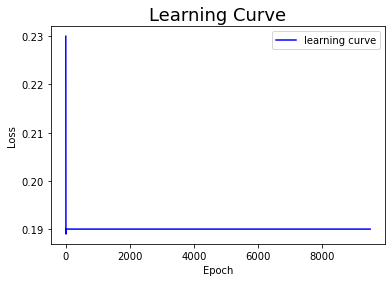

In [46]:
xorNNNon.trainNetwork(X_non_train, Y_non_train)

In [47]:
Y_non_predict = xorNNNon.predict(X_non_train)

Predict:0, [0.65832216 0.1637498 ]
Predict:1, [0.52567201 0.0225847 ]
Predict:2, [0.43451188 0.93678298]
Predict:3, [0.33772705 0.88961547]
Predict:4, [0.3503877  0.53866092]
Predict:5, [0.21677086 0.03510619]
Predict:6, [0.12353705 0.12133793]
Predict:7, [0.64706223 0.15528282]
Predict:8, [0.71906009 0.92687092]
Predict:9, [0.20445975 0.06083348]
Predict:10, [0.30953228 0.79573912]
Predict:11, [0.71142692 0.29322074]
Predict:12, [0.51657629 0.51358288]
Predict:13, [0.31552468 0.77308917]
Predict:14, [0.18818377 0.84520889]
Predict:15, [0.20962832 0.31739365]
Predict:16, [0.33897715 0.50889516]
Predict:17, [0.3884149  0.74266202]
Predict:18, [0.85110541 0.76629613]
Predict:19, [0.15560076 0.66887373]
Predict:20, [0.49864363 0.92665429]
Predict:21, [0.04696399 0.74536118]
Predict:22, [0.46878187 0.25853346]
Predict:23, [0.50026455 0.1677261 ]
Predict:24, [0.35248674 0.96805167]
Predict:25, [0.92658898 0.94066685]
Predict:26, [0.0056935  0.13282572]
Predict:27, [0.37045997 0.27165727]
Pr

print Red 0.038144851231252386
print Red 0.006499931078837118
print Red 0.8479691979219316
print Red 0.8725394187867512
print Red 0.5644669808480272
print Red 0.2241168403766884
print Red 0.36018415665686676
print Red 0.03845988723186672
print Red 0.6488934596637402
print Red 0.25432588719485366
print Red 0.8112893886550775
print Red 0.11309328530365537
print Red 0.43173208649909967
print Red 0.7879401117866107
print Blue 0.934808548335079
print Red 0.46987533400791476
print Red 0.5467012764439158
print Red 0.7131380655353559
print Red 0.42336422168555843
print Red 0.8061074278050425
print Red 0.7963620283408926
print Blue 0.9441747471046286
print Red 0.24602665771954613
print Red 0.14741949209261815
print Blue 0.9296089572673072
print Red 0.5216500021780698
print Red 0.44893218808191926
print Red 0.3230940378254018
print Red 0.421077407990013
print Red 0.3420578198463239
print Red 0.5735653774934685
print Blue 0.9638603206883756
print Red 0.7030032391791334
print Red 0.450468763547218

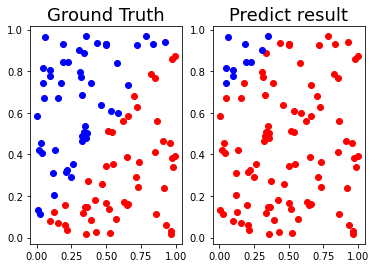

Accuracy--> 60.0%


In [48]:
show_result(X_non_train, Y_non_train, Y_non_predict)
show_accuracy(Y_non_train, Y_non_predict)